# Part 1

There's a lot to this one part! Here are some steps to think about.

1. Get the Fama-French Data. These are the two CSV files that need to be cleaned. We saw in class that the easiest thing to do is just drag the file into the Explorer window in your code space. You'll then add/commit/push the CSV files to your repo, like any other file. 

You can right-click on the file in the Explorer to get the file path. Use this path inside of pd.read_csv. That will import the CSV file into a pandas Dataframe.

2. Pick an etf.  You can use YFinance or just use one from the set of returns I provided you.

3. This leaves you with three files: mom, ff, etf. You now have to look carefully at them:

Are the returns in the same units?
Dates? Are they same format?
Are all your returns monthly? Can we go from daily to monthly?

4. Once the data are cleaned, you need to combine the files. Try an inner merge of all three files using Date. An inner merge will just keeps Dates that are in all three files.

This final dataframe will look something like: Date ETF Mkt_rf SMB HML MOM

5. Finally, you run the Carhart four-factor regression and interpret the output.

I'm going to make the Date an index on import.

In [1]:
import numpy as np
import pandas as pd

from pylab import mpl, plt

import scipy.optimize as sco

In [2]:
ff_clean = pd.read_csv('/workspaces/fin-data-sp25/ff_clean.csv',
                  index_col=0)
ff_clean

,Mkt-RF,SMB,HML,RF
Date,,,,
192607,2.96,-2.56,-2.43,0.22
192608,2.64,-1.17,3.82,0.25
192609,0.36,-1.40,0.13,0.23
192610,-3.24,-0.09,0.70,0.32
192611,2.53,-0.10,-0.51,0.31
...,...,...,...,...
202310,-3.19,-3.87,0.19,0.47
202311,8.84,-0.02,1.64,0.44
202312,4.87,6.34,4.93,0.43


In [3]:
mom_clean = pd.read_csv('/workspaces/fin-data-sp25/mom_clean.csv',
                  index_col=0)
mom_clean


,mom
Date,
192701,0.36
192702,-2.14
192703,3.61
192704,4.30
192705,3.00
...,...
202310,1.73
202311,2.75
202312,-5.51


In [4]:
ff_clean = ff_clean.div(100)
mom_clean = mom_clean.div(100)
mom_clean

,mom
Date,
192701,0.0036
192702,-0.0214
192703,0.0361
192704,0.0430
192705,0.0300
...,...
202310,0.0173
202311,0.0275
202312,-0.0551


I'm going to merge these two now. Now, I set the index to be the Date column for both. Remember, the index is a "special" thing, not a "real" column in your data frame. Here's the syntax for **merging two dataframes on the index**.

By setting both the index values to `True`, this is like an `inner` merge. The index needs to be in both data frames. 

From ChatGPT:

> Yes, by default, pd.merge performs an inner merge. When you use left_index=True and right_index=True, it merges the two DataFrames on their indices, keeping only the rows with indices that appear in both DataFrames. This is similar to an inner join in SQL, where the result includes only the rows that have matching keys in both tables.

In [5]:
factors = pd.merge(ff_clean, mom_clean, left_index=True, right_index=True)
factors


,Mkt-RF,SMB,HML,RF,mom
Date,,,,,
192701,-0.0006,-0.0037,0.0454,0.0025,0.0036
192702,0.0418,0.0004,0.0294,0.0026,-0.0214
192703,0.0013,-0.0165,-0.0261,0.0030,0.0361
192704,0.0046,0.0030,0.0081,0.0025,0.0430
192705,0.0544,0.0153,0.0473,0.0030,0.0300
...,...,...,...,...,...
202310,-0.0319,-0.0387,0.0019,0.0047,0.0173
202311,0.0884,-0.0002,0.0164,0.0044,0.0275
202312,0.0487,0.0634,0.0493,0.0043,-0.0551


Finally, I'm going to convert these weird yyyymm dates into proper month-end dates. 

In [6]:
factors.index = pd.to_datetime(factors.index, format='%Y%m') + pd.offsets.MonthEnd()
factors


,Mkt-RF,SMB,HML,RF,mom
Date,,,,,
1927-01-31,-0.0006,-0.0037,0.0454,0.0025,0.0036
1927-02-28,0.0418,0.0004,0.0294,0.0026,-0.0214
1927-03-31,0.0013,-0.0165,-0.0261,0.0030,0.0361
1927-04-30,0.0046,0.0030,0.0081,0.0025,0.0430
1927-05-31,0.0544,0.0153,0.0473,0.0030,0.0300
...,...,...,...,...,...
2023-10-31,-0.0319,-0.0387,0.0019,0.0047,0.0173
2023-11-30,0.0884,-0.0002,0.0164,0.0044,0.0275
2023-12-31,0.0487,0.0634,0.0493,0.0043,-0.0551


Nice.

Now, let's pull in some ETF returns. I'll use the YFinance tools. I'm copying the set-up directly from the package page. Let's walk through what you can do with it. 

In [7]:
import yfinance as yf
import datetime

qval = yf.Ticker("QVAL")

This gets you some kind of ticker object that contains a bunch of stuff. I've brought in an ETF with the ticker QVAL. It is a quantitative value fund run by a firm called Alpha Architect.  

In [8]:
type(qval)


yfinance.ticker.Ticker

Like, information about the ETF.

In [9]:
qval.info

{'longBusinessSummary': 'The Sub-Adviser employs a multi-step, quantitative, rules-based methodology to identify a portfolio of approximately 50 to 200 undervalued U.S. equity securities with the potential for capital appreciation. A security is considered to be undervalued when it trades at a price below the price at which the Sub-Adviser believes it would trade if the market reflected all factors relating to the company’s worth. The fund may also invest up to 20% of its assets in cash and cash equivalents, other investment companies, as well as securities and other instruments.',
 'companyOfficers': [],
 'executiveTeam': [],
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 40.93,
 'open': 40.69,
 'dayLow': 40.6056,
 'dayHigh': 40.88,
 'regularMarketPreviousClose': 40.93,
 'regularMarketOpen': 40.69,
 'regularMarketDayLow': 40.6056,
 'regularMarketDayHigh': 40.88,
 'trailingPE': 10.719597,
 'volume': 16366,
 'regularMarketVolume': 16366,
 'averageVolume': 29561,
 'averageVolume10d

See the fund description above? Neat!

Now, let's bring in returns. YFinance brings in daily data, as you can see from the Date column. 2019 seems like a fun place to start.

Something strange - I had to use a start date of 2018-12-28 to get it to pull in 2018-12-31. I wanted that last December closing price, so that I can have a return for the first trading day of January. I'm playing with the start date and I think it is starting at that date, but not including it. Kind of like how some of the `.iloc` stuff works.

In [10]:
hist = qval.history(start="2018-12-28", end="2023-12-31")
hist[1:60]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2018-12-31 00:00:00-05:00,22.420341,22.424802,22.183868,22.342707,85600,0.000,0.0,0.0
2019-01-02 00:00:00-05:00,22.112474,22.790662,22.112474,22.688040,31300,0.000,0.0,0.0
2019-01-03 00:00:00-05:00,22.335560,22.469412,22.133888,22.133888,10700,0.000,0.0,0.0
2019-01-04 00:00:00-05:00,22.603267,22.951284,22.555079,22.942360,30900,0.000,0.0,0.0
2019-01-07 00:00:00-05:00,22.969130,23.558082,22.969130,23.415306,29600,0.000,0.0,0.0
2019-01-08 00:00:00-05:00,23.468850,23.638397,23.317150,23.624121,2700,0.000,0.0,0.0
2019-01-09 00:00:00-05:00,24.029240,24.209495,23.977485,24.064041,9100,0.000,0.0,0.0
2019-01-10 00:00:00-05:00,23.825787,24.037273,23.790092,24.037273,1600,0.000,0.0,0.0
2019-01-11 00:00:00-05:00,23.923945,24.096170,23.923945,24.080999,900,0.000,0.0,0.0


You can change that and get just monthly data. But, it looks like the start of the month to me. I like end of month, so that I can calculate returns from the close.

In [11]:
hist2 = qval.history(start="2018-11-01", end="2023-12-31", interval="1mo")
hist2[1:30]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2018-12-01 00:00:00-05:00,25.904831,26.135175,21.137598,22.182119,490100,0.180,0.0,0.0
2019-01-01 00:00:00-05:00,22.112475,25.592646,22.112475,25.592646,197100,0.000,0.0,0.0
2019-02-01 00:00:00-05:00,25.563196,26.770548,25.244628,26.075407,339300,0.000,0.0,0.0
2019-03-01 00:00:00-05:00,26.449305,26.636699,24.762760,25.605141,239700,0.085,0.0,0.0
2019-04-01 00:00:00-04:00,25.883726,27.244144,25.883726,26.795742,115900,0.000,0.0,0.0
2019-05-01 00:00:00-04:00,26.904048,26.904048,23.031333,23.046549,339200,0.000,0.0,0.0
2019-06-01 00:00:00-04:00,23.418869,25.173987,23.303413,25.097910,331900,0.146,0.0,0.0
2019-07-01 00:00:00-04:00,25.662986,26.103899,25.132089,25.579302,224100,0.000,0.0,0.0
2019-08-01 00:00:00-04:00,25.626991,25.626991,22.857333,23.654577,218400,0.000,0.0,0.0


Here's another way to download just the price data. I think this method is a bit more straightforward. OHLC = Open High Low Close.

In [12]:
qval_ohlc = yf.download("QVAL", start="2018-12-28", end="2024-01-03")
qval_ohlc[1:60]

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,QVAL,QVAL,QVAL,QVAL,QVAL
Date,,,,,
2018-12-31,22.342697,22.424793,22.183859,22.420332,85600
2019-01-02,22.688040,22.790662,22.112474,22.112474,31300
2019-01-03,22.133888,22.469412,22.133888,22.335560,10700
2019-01-04,22.942362,22.951286,22.555081,22.603269,30900
2019-01-07,23.415312,23.558088,22.969136,22.969136,29600
2019-01-08,23.624121,23.638397,23.317150,23.468850,2700
2019-01-09,24.064045,24.209498,23.977488,24.029244,9100
2019-01-10,24.037277,24.037277,23.790095,23.825790,1600


`Date` is again the index for this data frame. You don't got the dividend and capital gains info, though.

Now, notice the Adj Close. This stands for **Adjusted Close**. The adjusted close is going to take dividends (and other things) into account. You can read about it here: <https://finance.zacks.com/stock-return-using-adjusted-closing-price-11628.html> and at <https://www.investopedia.com/terms/a/adjusted_closing_price.asp>.

Let's start by keeping just month-end observations. Then, I'll calculate monthly returns from the month-end closing adjusted prices. 

Notice how I keep the month-end data. I group by 'index.year' and 'index.month'. Remember, 'index' is our 'Date'. This is putting our data into groups. I then keep `.tail(1)`, or the last value in that group.


In [13]:
qval_ohlc_m = qval_ohlc.groupby([qval_ohlc.index.year, qval_ohlc.index.month]).tail(1)
qval_ohlc_m.head()

Price,Close,High,Low,Open,Volume
Ticker,QVAL,QVAL,QVAL,QVAL,QVAL
Date,,,,,
2018-12-31,22.342697,22.424793,22.183859,22.420332,85600
2019-01-31,25.592642,25.592642,25.405247,25.405247,4900
2019-02-28,26.075409,26.110210,26.003127,26.012051,1100
2019-03-29,25.681459,25.740530,25.570478,25.740530,11900
2019-04-30,26.795752,26.939850,26.566630,26.859298,2600


I now I can calculate returns as usual.

In [14]:
qval_ohlc_m.loc[:, 'qval_ret'] = qval_ohlc_m['Close'].pct_change()
qval_ohlc_m.head()

/tmp/ipykernel_16060/1567273088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qval_ohlc_m.loc[:, 'qval_ret'] = qval_ohlc_m['Close'].pct_change()


Price,Close,High,Low,Open,Volume,qval_ret
Ticker,QVAL,QVAL,QVAL,QVAL,QVAL,
Date,,,,,,
2018-12-31,22.342697,22.424793,22.183859,22.420332,85600,NaN
2019-01-31,25.592642,25.592642,25.405247,25.405247,4900,0.145459
2019-02-28,26.075409,26.110210,26.003127,26.012051,1100,0.018864
2019-03-29,25.681459,25.740530,25.570478,25.740530,11900,-0.015108
2019-04-30,26.795752,26.939850,26.566630,26.859298,2600,0.043389


I think that you could do this daily to monthly return calculation using `resample` from `pandas`. But, I ran into trouble with it not understanding that the end of the month for trading isn't necessarily the end of the actual month. This way seemed easier. 

I'm just going to keep `qval_ret` now. I'm ready to merge with the factor data.

In [15]:
qval_ret = qval_ohlc_m[['qval_ret']].dropna()
qval_ret

Price,qval_ret
Ticker,
Date,
2019-01-31,0.145459
2019-02-28,0.018864
2019-03-29,-0.015108
2019-04-30,0.043389
2019-05-31,-0.139918
...,...
2023-09-29,0.003217
2023-10-31,-0.048451


Let's just keep the 2019 through 2023.

In [16]:
qval_ret = qval_ret[(qval_ret.index.year >= 2019) & (qval_ret.index.year <= 2023)]
qval_ret


Price,qval_ret
Ticker,
Date,
2019-01-31,0.145459
2019-02-28,0.018864
2019-03-29,-0.015108
2019-04-30,0.043389
2019-05-31,-0.139918
2019-06-28,0.094866
2019-07-31,0.013729
2019-08-30,-0.075245


Cool - let's merge. But first, I need to "flatten" the qval returns. By using Yahoo! to get prices and then calculate my returns, I have ended up with a two-level DataFrame. The merge won't work until I change this.

You can see this above - the column name is ('qval_ret', ''). That comma means it still has two-levels, even if one of the levels doesn't have a name.

In [22]:
# Flatten multi-level columns if present
if isinstance(qval_ret.columns, pd.MultiIndex):
    qval_ret.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in qval_ret.columns]

if isinstance(factors.columns, pd.MultiIndex):
    factors.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in factors.columns]

In [24]:
all = pd.merge(factors, qval_ret, left_index=True, right_index=True)
all


,Mkt-RF,SMB,HML,RF,mom,qval_ret_
Date,,,,,,
2019-01-31,0.0840,0.0290,-0.0046,0.0021,-0.0868,0.145459
2019-02-28,0.0340,0.0205,-0.0267,0.0018,0.0086,0.018864
2019-04-30,0.0397,-0.0174,0.0215,0.0021,-0.0297,0.043389
2019-05-31,-0.0694,-0.0132,-0.0237,0.0021,0.0756,-0.139918
2019-07-31,0.0119,-0.0193,0.0048,0.0019,0.0289,0.013729
2019-09-30,0.0143,-0.0096,0.0675,0.0018,-0.0681,0.064479
2019-10-31,0.0206,0.0029,-0.0191,0.0016,0.0015,0.052046
2019-12-31,0.0277,0.0073,0.0175,0.0014,-0.0177,0.013525
2020-01-31,-0.0011,-0.0311,-0.0625,0.0013,0.0598,-0.063445


Good - see how none of the column names are in parentheses? 

Can you believe that we finally got here? Our data is clean. It is ready. We can run a regression and actually do some finance. 

You'll have to do a `pip install statsmodels` to get the package. Then, import like I do below.

Remember, you need to `pip` certain packages into every new code space, if the code space doesn't come with it. I was surpirsed this one was missing. 

In [25]:
all.describe()

,Mkt-RF,SMB,HML,RF,mom,qval_ret_
count,42.000000,42.000000,42.000000,42.000000,42.00000,42.000000
mean,0.014648,-0.002455,-0.002555,0.001531,-0.00214,0.015057
std,0.056694,0.027485,0.049566,0.001577,0.04897,0.086231
min,-0.133900,-0.059400,-0.138700,0.000000,-0.16010,-0.280534
25%,-0.023650,-0.019050,-0.023275,0.000100,-0.02445,-0.022904
50%,0.026300,-0.001200,-0.004550,0.001350,0.00805,0.024400
75%,0.046225,0.016625,0.020050,0.002250,0.02675,0.053293
max,0.136500,0.058000,0.127500,0.004700,0.07970,0.161237


In [ ]:
all.info()

I'm going to rename these columns. I was trying to run the regression and `smf` didn't like some of hte names. That dash I think.

In [26]:
all.rename(columns={'Mkt-RF': 'mkt_rf'}, inplace=True)
all.rename(columns={'SMB': 'smb'}, inplace=True)
all.rename(columns={'HML': 'hml'}, inplace=True)
all.rename(columns={'RF': 'rf'}, inplace=True)
all.rename(columns={'qval_ret_': 'qval_ret'}, inplace=True)




Now, here's something really fun. I can't get my code to recognize `mom` as a variable/column name. Let's see why.

In [27]:
all.columns

Index(['mkt_rf', 'smb', 'hml', 'rf', 'mom   ', 'qval_ret'], dtype='object')

Awesome. The CSV file brought in a bunch of white space on import. See how it looks like `mom` everywhere? But when I print the actual columns it isn't really `mom`.

This will get rid of the white space for all columns.

In [28]:
all.columns = [col.strip() for col in all.columns]


In [29]:
all.columns

Index(['mkt_rf', 'smb', 'hml', 'rf', 'mom', 'qval_ret'], dtype='object')

In [30]:
all.head()

,mkt_rf,smb,hml,rf,mom,qval_ret
Date,,,,,,
2019-01-31,0.0840,0.0290,-0.0046,0.0021,-0.0868,0.145459
2019-02-28,0.0340,0.0205,-0.0267,0.0018,0.0086,0.018864
2019-04-30,0.0397,-0.0174,0.0215,0.0021,-0.0297,0.043389
2019-05-31,-0.0694,-0.0132,-0.0237,0.0021,0.0756,-0.139918
2019-07-31,0.0119,-0.0193,0.0048,0.0019,0.0289,0.013729


In [31]:
import statsmodels.formula.api as smf

model = smf.ols(formula='qval_ret ~ mkt_rf + smb + hml + mom', data = all)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               qval_ret   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     87.93
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           2.25e-18
Time:                        18:08:13   Log-Likelihood:                 93.232
No. Observations:                  42   AIC:                            -176.5
Df Residuals:                      37   BIC:                            -167.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002      0.005     -0.053      0.9

So, can you tell what this fund does? What do you think?

# Part 2

Our textbook provides the "raw" Iowa housing price data as well. You can find it on our Github page: <https://github.com/aaiken1/fin-data-analysis-python/blob/b387722facf1809f9fd1cc1fcb8d9059e7090c78/data/Original_Data.xlsx>

Note that it is an **Excel file, not a CSV file**. You might need to do a `pip install openpyxl` in your terminal in order to get `pd.read_excel` to work. What's the difference between and Excel file and a CSV file? Do you see why data folks prefer CSV files? No need to answer, just something to think about.

We are going to try a **more unstructured problem**. This actually a modified version of Excerise 3.15 from the Hull text. I would like you to import this data. Check out the variables. Do you notice anything about them, compared to what we saw in our notes?

Be careful with the file - is it exactly what you need when you import it?

I want you to run the same linear regression model as in the text and notes. However, you should also do the following:

- Keep the variables that were in the original model, except for the neighborhood indicators. 

- Include `LotFrontage` as a feature.

- Create a **categorical feature** based on `LotShape`. So, each possible value of LotShape will be a new variable with a True or False value. See the notes for how you might do this. The method I used created **boolean** values for each of the new variables. I then converted these to 1 or 0 **integer** values (e.g. True = 1). I think the integer values are easier to deal with. Not every method knows what to do with a boolean.

- What could you do for **missing values**? Check out <https://feaz-book.com/missing-simple>. Try doing some simple imputation for a column with missing values. `sklearn` will help you. I asked ChatGPT and Claude for help on filling in the missing values for LotFrontage based on the median value. Missing values are special and need to be handled with care. When dealing with your own data, it's one of the first things you check. If there are missing values, you really, really need to understand why. For indicator variables (i.e. variables that can be 1/0), or the missings really zeroes? Maybe?

- **Standardize the variables**. This is what I wanted you to notice above. This is the **raw data** - no feature engineering has been done. 

- As in the analysis in the text, choose the first 1,800 observations as the training set, the next 600 as the validation set, and the remainder as the test set. Reminder - **why do we need three different data sets?** No need to write an answer, but make sure you understand the process. 

- Run a **linear regression** model and discuss your output. Use the model to predict values **out of sample**. Be careful - if there are missing values, strange data types, etc. the model might not run. You need to make sure that your data is exactly what you want.

- Choose **two regularization** methods and report the prediction results. How did you choose your **hyperparameters**? Pay attention to the difference between the **alpha** parameter and the **lambda** parameter. Try different values within your **training** data. This will give you sense of what works. The notes have an example of **cross validation**, though the textbook doesn't really get into this. Then, use a model with varying parameters on your **validation** data. Pick the parameter that performs best. Fit your model to the **combined training and validation data sets** Finally, try that one model on your **test data** to predict sales price.

Remember, **X are the features of our homes. y are the sales price**.

Here are the steps that ClaudeGPT recommends:

To use a validation training set to choose hyperparameters for a machine learning model, you can follow these steps:

- **Split the data into training, validation, and test sets**. Typically, you would split the data into three parts: a training set, a validation set, and a test set. The training set is used to train the model, the validation set is used to tune the hyperparameters, and the test set is used to evaluate the final model performance.

- **Define the hyperparameters to tune**. Identify the hyperparameters of your model that you want to tune, such as the regularization parameter (e.g., alpha in Lasso regression), the learning rate, the number of trees in a random forest, etc.

- **Perform cross-validation on the training set**. Use a technique like k-fold cross-validation on the training set to evaluate the model's performance for different hyperparameter values. This will help you understand how the model performs on unseen data within the training set.

- **Use the validation set to select the best hyperparameters**. After the cross-validation on the training set, you will have a set of hyperparameter values and their corresponding performance metrics (e.g., accuracy, R-squared). Use the validation set to evaluate the model's performance for each set of hyperparameters and select the one that performs best on the validation set.

I found this code helpful for a LASSO model.

```
# Tune the LASSO hyperparameter (alpha) using the validation set
param_grid = {'alpha': [0.001, 0.01, 0.02, .05, 0.1]}
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid_search.fit(X_val, y_val)

# Extract the R-squared scores for each fold and hyperparameter combination
r2_scores = grid_search.cv_results_['mean_test_score']

# Print the R-squared scores
print(r2_scores)
```

What is this doing? What is `cv=5`? What is `r2`? Have you brought in all of the packages that you need?

- **Retrain the model with the selected hyperparameters**. Once you have chosen the best hyperparameters based on the validation set, retrain the final model using the full training set (both the original training set and the validation set). So, you'll need to combine two of your datasets. 

If you do that grid search above, how can you pull the "best" alpha value and use it in your final model?

- **Evaluate the final model on the test set**. Remember, the big picture. You have used the test and validation data to pick a "best" alpha value. Or multiple values, if you're doing ElasticNet. You then **fit the model** with that paramter on the combined training and validation data. You then use the **b values (coefficients)** from this model to predict values of y, given the X test data. Finally, you compare your predicted values of y with the actual values of y in the test data. Models give us **a (bias) and b (weights)** values. These can be used to **predict** the y value.  


This solution is going to be a **running narrative** of sorts. I'll walk you through my thought process, as I looked at the data and the task before me.

I'll start with some typical set-up code. I like to put all of my imports **at the top of my code**, rather than scattered throughout. Keeps things organized.

In [1]:
# Set-up

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.linear_model import LinearRegression

# Importing Ridge
from sklearn.linear_model import Ridge

# Import Lasso
from sklearn.linear_model import Lasso

# For splitting data and doing a hyper parameter grid search
from sklearn.model_selection import train_test_split, GridSearchCV


# Import Elastic Net
from sklearn.linear_model import ElasticNet

#Need for AIC/BIC cross validation example
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

# For standardization
from sklearn.preprocessing import StandardScaler

# For Imputation
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer



I'll bring in my data. I had to install `openpyxl` to use `pd.read_excel`. Note the skips rows! I first imported the data and then noticed that the first three rows in the Excel file were blank. I asked Copilot how to skip rows on import.

In [2]:
url = 'https://github.com/aaiken1/fin-data-analysis-python/raw/b387722facf1809f9fd1cc1fcb8d9059e7090c78/data/Original_Data.xlsx'
housing = pd.read_excel(url, skiprows=3)

Let's look. Notice that I don't use `print()` very much in Jupyter Notebooks. I'm looking at the number of rows and columns, getting a sense for what I have.

There's an `Id` variable. I may or may not need this.

In [3]:
housing

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Unnamed: 81,Unnamed: 82
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,NaN,NaN
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,NaN,NaN
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,NaN,NaN
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,NaN,NaN
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2903,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,6,2006,WD,Normal,90500,NaN,NaN
2904,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,4,2006,WD,Abnorml,71000,NaN,NaN
2905,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,9,2006,WD,Abnorml,131000,NaN,NaN
2906,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,MnPrv,Shed,700,7,2006,WD,Normal,132000,NaN,NaN


I renamed `Id` to `id` because it was bothering me. If I was being really careful, I would use something like `pyjanitor` to clean-up all of the column names.

I then set `id` to be my index, removing it as a column. Remember, the index is a special `pandas` thing. Some people like it, others find it annoying. 

In [4]:
# Set the 'id' column as the row index
housing.rename(columns={'Id': 'id'}, inplace=True)

housing = housing.set_index('id')


I noticed some "extra" columns that started with *Unnamed* got brought in. I use some **regex** to drop them. **regex**, or **regular expressions** is way of parsing text. I used to be able to write and read it some. Now, I just asked Copilot to drop any column that contains the text "Unnamed".

In [5]:
housing = housing.filter(regex=r'^(?!Unnamed)')


That step above wasn't strictly necessary. After looking at my columns, I decide to just keep the ones that I want anyway.

I do like the `print()` the columns, so that I can copy and paste the names easier, as needed. There's probably a fancier way to do that, without the copy and pasting, but it only took a minute or two.

In [6]:
columns = housing.columns
print(columns)


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Let's just keep what I want. Notice I use a **list** of the columns I want to subset my dataframe. 

In [7]:
housing_subset = housing[['LotFrontage', 'LotShape', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice']]

OK, let's take a look at *LotShape*.

In [8]:
housing_subset['LotShape'].unique()

array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)

I'll use `pd.get_dummies` to create new columns based on those four values. Every observation gets a *True* or *False* based on whether or not they have that particular *LotShape*. *LotShape* is mutuall exclusive, so an observation can only get a *True* for one of the dummies/indicators/categorical variables. 

`pd.get_dummies` creates a new data frame with the new columns. I use `pd.concat` to add them back to my main data frame. I drop the original `LotShape` value when I'm done creating my indicators. 

I did all of this using Copilot. I'm having a **conversation with my data**. 

In [9]:
# Create categorical variable based on LotShape
lot_shape_categorical = pd.get_dummies(housing['LotShape'], prefix='LotShape')

# Concatenate the categorical variable with the original DataFrame
housing_subset = pd.concat([housing_subset, lot_shape_categorical], axis=1)

housing_subset = housing_subset.drop('LotShape', axis=1)



I switch the **boolean** True or False values to 1/0 integer values. `axis=1` refers to **columns**. This is why we spent a week or so doing some **basic Python** at the start of the semester. Even with Copilot and various AI tools, we still need to understand when and why we want to do something, what the data we're dealing with actually means. This helps to **inform our conversation with our data**. 

In [10]:
housing_subset = housing_subset.astype({col: int for col in housing_subset.select_dtypes(include='bool')})
housing_subset

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SalePrice,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg
id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,706,0,150,856,...,2,548,0,61,0,208500,0,0,0,1
2,80.0,9600,6,8,1976,1976,978,0,284,1262,...,2,460,298,0,0,181500,0,0,0,1
3,68.0,11250,7,5,2001,2002,486,0,434,920,...,2,608,0,42,0,223500,1,0,0,0
4,60.0,9550,7,5,1915,1970,216,0,540,756,...,3,642,0,35,272,140000,1,0,0,0
5,84.0,14260,8,5,2000,2000,655,0,490,1145,...,3,836,192,84,0,250000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,21.0,1936,4,7,1970,1970,0,0,546,546,...,0,0,0,0,0,90500,0,0,0,1
2916,21.0,1894,4,5,1970,1970,252,0,294,546,...,1,286,0,24,0,71000,0,0,0,1
2917,160.0,20000,5,7,1960,1996,1224,0,0,1224,...,2,576,474,0,0,131000,0,0,0,1


I'm looking again all of my variables, looking at data types and for missing values. In a Jupyter Notebook, you can always **view as a scrollable** element in order to see the full list. Just **click below the output**.

In [11]:
housing_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2908 entries, 1 to 2919
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    2422 non-null   float64
 1   LotArea        2908 non-null   int64  
 2   OverallQual    2908 non-null   int64  
 3   OverallCond    2908 non-null   int64  
 4   YearBuilt      2908 non-null   int64  
 5   YearRemodAdd   2908 non-null   int64  
 6   BsmtFinSF1     2908 non-null   int64  
 7   BsmtFinSF2     2908 non-null   int64  
 8   BsmtUnfSF      2908 non-null   int64  
 9   TotalBsmtSF    2908 non-null   int64  
 10  1stFlrSF       2908 non-null   int64  
 11  2ndFlrSF       2908 non-null   int64  
 12  GrLivArea      2908 non-null   int64  
 13  FullBath       2908 non-null   int64  
 14  HalfBath       2908 non-null   int64  
 15  BedroomAbvGr   2908 non-null   int64  
 16  TotRmsAbvGrd   2908 non-null   int64  
 17  Fireplaces     2908 non-null   int64  
 18  GarageCars   

Let's do an official count.

In [12]:
missing_values_count = housing_subset.isnull().sum()
missing_values_count = pd.DataFrame(missing_values_count).sort_values(by=0, ascending=False)
missing_values_count.head(25)

,0
LotFrontage,486
LotArea,0
LotShape_IR3,0
LotShape_IR2,0
LotShape_IR1,0
SalePrice,0
EnclosedPorch,0
OpenPorchSF,0
WoodDeckSF,0
GarageArea,0


OK, only one variable is a problem. I'm going to use `SimpleImputer` from `sklearn` to replace every missing value of *LotFrontage* with the median value. 

In [13]:
imputer = SimpleImputer(strategy='median')

# Fit and transform the 'LotFrontage' column
housing_subset_imputed = housing_subset.copy()
housing_subset_imputed['LotFrontage'] = imputer.fit_transform(housing_subset[['LotFrontage']])

housing_subset_imputed.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2908 entries, 1 to 2919
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    2908 non-null   float64
 1   LotArea        2908 non-null   int64  
 2   OverallQual    2908 non-null   int64  
 3   OverallCond    2908 non-null   int64  
 4   YearBuilt      2908 non-null   int64  
 5   YearRemodAdd   2908 non-null   int64  
 6   BsmtFinSF1     2908 non-null   int64  
 7   BsmtFinSF2     2908 non-null   int64  
 8   BsmtUnfSF      2908 non-null   int64  
 9   TotalBsmtSF    2908 non-null   int64  
 10  1stFlrSF       2908 non-null   int64  
 11  2ndFlrSF       2908 non-null   int64  
 12  GrLivArea      2908 non-null   int64  
 13  FullBath       2908 non-null   int64  
 14  HalfBath       2908 non-null   int64  
 15  BedroomAbvGr   2908 non-null   int64  
 16  TotRmsAbvGrd   2908 non-null   int64  
 17  Fireplaces     2908 non-null   int64  
 18  GarageCars   

Time to scale the data. I have everything set-up the way I want it. My data frame only has the y (target) and X (features) that I want. Nothing more, nothing less. I'll split things up into y and X, train and test, in a second.

All of my columns are numbers, but I select only the numerical columns to standardize, just to be safe. Remember, what does this type of `StandardScaler()` do? Why do people do this in machine learning?

In [14]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the data
numerical_cols = housing_subset_imputed.select_dtypes(include='number').columns

numerical_cols



Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice',
       'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg'],
      dtype='object')

In [15]:
housing_subset_imputed[numerical_cols] = scaler.fit_transform(housing_subset_imputed[numerical_cols])

housing_subset_imputed.head()



,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SalePrice,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg
id,,,,,,,,,,,,,,,,,,,,,
1,-0.188463,-0.214321,0.656090,-0.510046,1.047463,0.897719,0.616706,-0.293627,-0.934304,-0.455573,...,0.309173,0.355477,-0.739458,0.208626,-0.359167,0.361313,-0.703098,-0.163817,-0.072006,0.753429
2,0.535895,-0.066755,-0.060092,2.189979,0.155412,-0.395305,1.239499,-0.293627,-0.629584,0.511453,...,0.309173,-0.055496,1.621119,-0.706865,-0.359167,0.015716,-0.703098,-0.163817,-0.072006,0.753429
3,-0.043591,0.144970,0.656090,-0.510046,0.981385,0.849829,0.112976,-0.293627,-0.288480,-0.303135,...,0.309173,0.635686,-0.739458,-0.076527,-0.359167,0.553311,1.422276,-0.163817,-0.072006,-1.327265
4,-0.429915,-0.073171,0.656090,-0.510046,-1.859960,-0.682643,-0.505238,-0.293627,-0.047432,-0.693756,...,1.623612,0.794471,-0.739458,-0.181583,3.878297,-0.515480,1.422276,-0.163817,-0.072006,-1.327265
5,0.729057,0.531208,1.372273,-0.510046,0.948346,0.754050,0.499932,-0.293627,-0.161134,0.232778,...,1.623612,1.700479,0.781451,0.553812,-0.359167,0.892508,1.422276,-0.163817,-0.072006,-1.327265


Just checking to make sure that I still have a data frame. Depending on exactly how you use the scaler, you might get back an array. You can always change the array to a data frame and add the column names back. 

Arrays are simpler than data frames. Think a matrix in math vs. an Excel file. **Again, this is why we need to know some of the Python basics.** 

In [16]:
type(housing_subset_imputed)

pandas.core.frame.DataFrame

I find it strange to standardize year and month variables. I'd like to read more about what people do in these situations. Hull standardizes `YrBuilt` in his example.

In [17]:
housing_subset_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2908 entries, 1 to 2919
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    2908 non-null   float64
 1   LotArea        2908 non-null   float64
 2   OverallQual    2908 non-null   float64
 3   OverallCond    2908 non-null   float64
 4   YearBuilt      2908 non-null   float64
 5   YearRemodAdd   2908 non-null   float64
 6   BsmtFinSF1     2908 non-null   float64
 7   BsmtFinSF2     2908 non-null   float64
 8   BsmtUnfSF      2908 non-null   float64
 9   TotalBsmtSF    2908 non-null   float64
 10  1stFlrSF       2908 non-null   float64
 11  2ndFlrSF       2908 non-null   float64
 12  GrLivArea      2908 non-null   float64
 13  FullBath       2908 non-null   float64
 14  HalfBath       2908 non-null   float64
 15  BedroomAbvGr   2908 non-null   float64
 16  TotRmsAbvGrd   2908 non-null   float64
 17  Fireplaces     2908 non-null   float64
 18  GarageCars   

Let's split up the data. I'll follow Hull and use training, validation, and testing data sets.

In [18]:
train = housing_subset_imputed.iloc[:1800] 
val = housing_subset_imputed.iloc[1800:2400]
test = housing_subset_imputed[2400:]

train_obs = train.shape[0]
val_obs = val.shape[0]
test_obs = test.shape[0]

print("Number of observations in train dataset:", train_obs)
print("Number of observations in val dataset:", val_obs)
print("Number of observations in test dataset:", test_obs)


Number of observations in train dataset: 1800
Number of observations in val dataset: 600
Number of observations in test dataset: 508


Now, I split those three data frames into the X and y subsets. So, I've got **six data frames to work with now**.

In [20]:
# Creating the "X" and "y" variables. We drop sale price from "X"
X_train, X_val, X_test = train.drop('SalePrice', axis=1), val.drop('SalePrice', axis=1), test.drop('SalePrice', axis=1)
y_train, y_val, y_test = train[['SalePrice']], val[['SalePrice']], test[['SalePrice']] 

Let's peak. Here's my **standardized SalePrice** in the *y_train* data frame.

In [21]:
y_train.head()

,SalePrice
id,
1,0.361313
2,0.015716
3,0.553311
4,-0.515480
5,0.892508


And, all of my **standardized features**. Again, I **only have the features that I want**.

In [22]:
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg
id,,,,,,,,,,,,,,,,,,,,,
1,-0.188463,-0.214321,0.656090,-0.510046,1.047463,0.897719,0.616706,-0.293627,-0.934304,-0.455573,...,-0.925020,0.309173,0.355477,-0.739458,0.208626,-0.359167,-0.703098,-0.163817,-0.072006,0.753429
2,0.535895,-0.066755,-0.060092,2.189979,0.155412,-0.395305,1.239499,-0.293627,-0.629584,0.511453,...,0.629869,0.309173,-0.055496,1.621119,-0.706865,-0.359167,-0.703098,-0.163817,-0.072006,0.753429
3,-0.043591,0.144970,0.656090,-0.510046,0.981385,0.849829,0.112976,-0.293627,-0.288480,-0.303135,...,0.629869,0.309173,0.635686,-0.739458,-0.076527,-0.359167,1.422276,-0.163817,-0.072006,-1.327265
4,-0.429915,-0.073171,0.656090,-0.510046,-1.859960,-0.682643,-0.505238,-0.293627,-0.047432,-0.693756,...,0.629869,1.623612,0.794471,-0.739458,-0.181583,3.878297,1.422276,-0.163817,-0.072006,-1.327265
5,0.729057,0.531208,1.372273,-0.510046,0.948346,0.754050,0.499932,-0.293627,-0.161134,0.232778,...,0.629869,1.623612,1.700479,0.781451,0.553812,-0.359167,1.422276,-0.163817,-0.072006,-1.327265


Let's use `sklearn` to create a `LinearRegression()

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

The regression output from `sklearn` isn't great. Here's some generic code that spits our the variable names (plus intercept) and the coefficients. No statistical significance, though you could add that. 

**Machine learning** just isn't that interested in the t-statistics or interpretation, generally speaking. We are going to use these coefficients for **prediction**. 

In [24]:
# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.016161
LotFrontage,0.05688
LotArea,0.04948
OverallQual,0.281919
OverallCond,0.070921
YearBuilt,0.144879
YearRemodAdd,0.049701
BsmtFinSF1,0.128157
BsmtFinSF2,0.001757


We can print the R-Square value for the model. This is a measure of **model fit**.

In [25]:
lr.score(X_train,y_train)

0.8645213139880266

Let's use `statsmodel` to do the same regression using our training data. I like this output - it's what I use to seeing. Do the coefficients and signs make sense? What's statitically significant (i.e important) in the model?

In [26]:
x = sm.add_constant(X_train)

#fit linear regression model
model = sm.OLS(y_train, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     452.8
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:18:35   Log-Likelihood:                -733.61
No. Observations:                1800   AIC:                             1519.
Df Residuals:                    1774   BIC:                             1662.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0162      0.009     -1.867

Back to `sklearn`. I can use the coefficients from the fitted model above to **predict y values using data that is not in the training set**.

`lr.predict` takes the coefficients and uses them with another set of oberservations that I **held out** of the training, my original model estimating. These features are in **X_val**, my validation data. 

My coefficients are stored in the **object** `lr`. `lr.predict` applies them to X_val.

I then compare the **predicted y values** to the **actual y values** for each observation. Notice that each row in y_val and y_pred correspond to the **same observation**. **y_val** has the actual price. **y_pred** has the predicted price. 

In [27]:
# Make predictions using the testing set
y_pred = lr.predict(X_val)

# The coefficients
print("Coefficients: \n", lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mse(y_val, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2(y_val, y_pred))

Coefficients: 
 [[ 0.05688021  0.04948034  0.28191864  0.07092133  0.14487917  0.04970132
   0.12815704  0.00175688  0.00490814  0.13916497  0.1674166   0.1945697
   0.13900547 -0.03168019 -0.00660821 -0.12882205  0.08262223  0.02399949
   0.02345523  0.06119555  0.02297997  0.03058711  0.00466663 -0.00092519
   0.02305504  0.00158064 -0.00698288]]
Mean squared error: 0.13
Coefficient of determination: 0.88


The two have an 88% correlation with each other. I guess that's good?

Let's look at things visually. Copilot made this code for me. Can you read it and tell what it does?

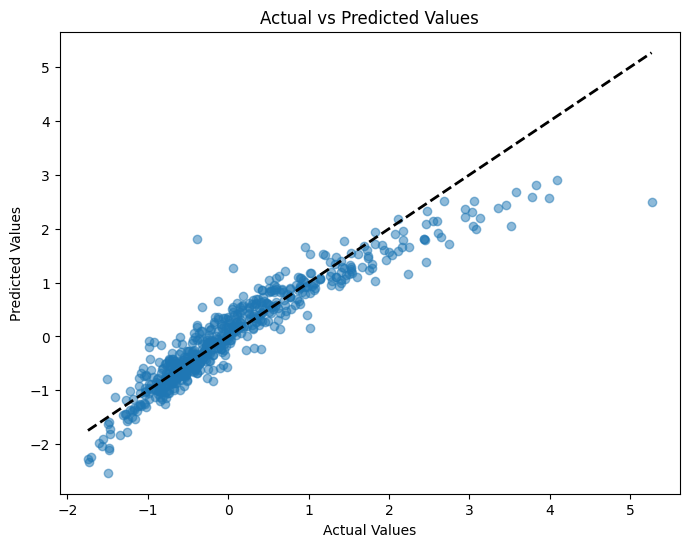

In [28]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot of actual vs predicted values
ax.scatter(y_val, y_pred, alpha=0.5)

# Add a diagonal line for reference
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)

# Set labels and title
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Show the plot
plt.show();

I just used the training and validation data for the linear regression. I think I didn't really need to do the three splits, I could have just done training and testing. The **training, validation, and testing split** is really for finding **hyperparameters** for your LASSO and Ridge models.

So, let's do a **LASSO**. **Chapter 1 of the Hull text** discusses how to use the training, validation, and testing data splits. Basically, he has you run a model using the training data. Then, you take the fitted model and try it with the validation data. Did it work well? Was it **overfit** to the training data?

You can go back and forth between the training and validation data, trying different model forms and **hyperparamters**. Notice that you might try OLS, Ridge, LASSO, ElasticNet. You'll try different hyperparamters, different lambda (alpha) values. This is the **machine learning part**. You're selecting the model that you think will do the best job predicting your data. 

The way Hull approaches things, you have a conversation between your training and validation data.

Other approaches just have two splits, training and testing, and do something called cross-fold validation within the training set to find your model and model hyperparameters. 

You then settle on a particular model. You can **combine the training and validation data into one sample**. Fit the final model. You then **evaluate the performance with the testing data**.

Notice how the **testing data** is never used until the final step. The model has never seen this data before. Can it make good predictions from it?

From Hull, Chapter 3:

> The training set is used to determine parameters for trial models. The validation set is used to determine the extent to which the models created from the training set generalize to new data. The test set is used as a final estimate of the accuracy of the chosen model.

I'm going to look at the two samples, the training and a validation sample. With the number of samples (n) = 2, the alpha will be half the lambda value, by definition. See the Hull text for more. Let's try to some different lasso models with different alphas, like in the notes.

I start by fitting the model to the **training data**. That's my largest sample. I'll start with an alpha of 0.05, which is the same as a lambda of 0.1, given our samples. I also made sure to include an **intercept**. The default is *True*, but I like to be precise. If one model has an intercept and another doesn't, it can be difficult to compare them.

In [29]:
# Train the LASSO model on the training set
lasso = Lasso(alpha=0.05, fit_intercept=True)
lasso.fit(X_train, y_train)

Lasso(alpha=0.05)

Let's look at the R-Squared value.

In [30]:
r_squared = lasso.score(X_train, y_train)
print("R-squared:", r_squared)


R-squared: 0.8436572069559101


Now, I'm going to try something here. We are going to use **cross-fold validation**, which is a bit differet from what Hull does in the book. 

I'm going to combine my training and validation data sets. You'll see me create X_combined and y_combined below.

I am then going to have `sklearn` run the model with different alpha (lambda) values within that combined data set. But, I'm going to have `GridSearchCV` split my data into five pieces. It is going to pick an alpha train my model using four pieces of the data. It is then going to test the model using the fifth part of the data and calculate the R-Squared value for that prediction. For each alpha, it is going to do that five times, holding one a different part of the sample each time. It will then report the **average R-Square** for each alpha across the five models.

I think I like this method better than the specific steps that Hull takes. 

More from Claude:

Cross-fold validation is a technique used to evaluate the performance of a machine learning model on a limited dataset. It is particularly useful when you don't have enough data to split it into separate training and testing sets.

Here's how cross-fold validation works:
- Divide the dataset: The dataset is divided into k (usually 5 or 10) equal-sized subsets, called "folds".
- Train and test the model: The model is trained and tested k times. In each iteration: One of the k folds is set aside as the "test set". The remaining k-1 folds are used as the "training set". The model is trained on the training set and evaluated on the test set.
- Evaluate the model: The performance metrics (e.g., accuracy, F1-score, etc.) from the k iterations are averaged to get an estimate of the model's performance on the entire dataset.

In [31]:
X_combined = pd.concat([X_train, X_val], ignore_index=True)
X_combined

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg
0,-0.188463,-0.214321,0.656090,-0.510046,1.047463,0.897719,0.616706,-0.293627,-0.934304,-0.455573,...,-0.925020,0.309173,0.355477,-0.739458,0.208626,-0.359167,-0.703098,-0.163817,-0.072006,0.753429
1,0.535895,-0.066755,-0.060092,2.189979,0.155412,-0.395305,1.239499,-0.293627,-0.629584,0.511453,...,0.629869,0.309173,-0.055496,1.621119,-0.706865,-0.359167,-0.703098,-0.163817,-0.072006,0.753429
2,-0.043591,0.144970,0.656090,-0.510046,0.981385,0.849829,0.112976,-0.293627,-0.288480,-0.303135,...,0.629869,0.309173,0.635686,-0.739458,-0.076527,-0.359167,1.422276,-0.163817,-0.072006,-1.327265
3,-0.429915,-0.073171,0.656090,-0.510046,-1.859960,-0.682643,-0.505238,-0.293627,-0.047432,-0.693756,...,0.629869,1.623612,0.794471,-0.739458,-0.181583,3.878297,1.422276,-0.163817,-0.072006,-1.327265
4,0.729057,0.531208,1.372273,-0.510046,0.948346,0.754050,0.499932,-0.293627,-0.161134,0.232778,...,0.629869,1.623612,1.700479,0.781451,0.553812,-0.359167,1.422276,-0.163817,-0.072006,-1.327265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,-0.285044,-0.186347,-0.776275,-0.510046,-0.108899,-0.778423,-0.999809,-0.293627,2.272078,1.221240,...,-0.925020,1.623612,1.494993,-0.739458,-0.706865,-0.359167,-0.703098,-0.163817,-0.072006,0.753429
2396,-0.043591,-0.009012,-0.776275,0.389962,-0.174977,-0.874202,0.378579,-0.293627,-0.841069,-0.605629,...,0.629869,0.309173,-0.186260,0.369538,-0.106543,-0.359167,1.422276,-0.163817,-0.072006,-1.327265
2397,1.501706,-0.066755,-0.060092,-0.510046,-0.340171,-1.113651,0.374000,-0.293627,0.129942,0.406652,...,0.629869,0.309173,0.248064,-0.739458,-0.706865,-0.359167,1.422276,-0.163817,-0.072006,-1.327265
2398,0.197862,-0.174542,-0.060092,1.289971,-0.472327,0.706160,0.999083,-0.293627,-1.132145,-0.265026,...,-0.925020,-1.005266,-0.732667,-0.739458,-0.706865,-0.359167,-0.703098,-0.163817,-0.072006,0.753429


In [32]:
y_combined = pd.concat([y_train, y_val], ignore_index=True)
y_combined

,SalePrice
0,0.361313
1,0.015716
2,0.553311
3,-0.515480
4,0.892508
...,...
2395,-0.694679
2396,-0.067484
2397,-0.278682
2398,-0.502680


They both have 2400 observations - good! Now, to the model.

In [33]:
# Tune the LASSO hyperparameter (alpha) using the validation set
param_grid = {'alpha': [0.001, 0.01, 0.02, .05, 0.1]}
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid_search.fit(X_combined, y_combined)

# Extract the R-squared scores for each fold and hyperparameter combination
r2_scores = grid_search.cv_results_['mean_test_score']

# Print the R-squared scores
print(r2_scores)

[0.86132713 0.86152918 0.859858   0.84749147 0.82550017]


Looks like alpha = 0.01 has the highest R-Square value. Remember what the hyperparamters are doing. We're basically telling the LASSO model "how much to lasso"! 

However, we can have Lasso pick the best alpha value automatically. The first two lines below do that and then fit the model again just using that best alpha and the combined data.

I then use the **fitted model** with the test features to create **predicted y values**. I report the R-Squared. Pretty similar to the ones above.

In [34]:
# Evaluate the final model on the test set
lasso_final = Lasso(alpha=grid_search.best_params_['alpha'])
lasso_final.fit(X_combined, y_combined)

y_pred = lasso_final.predict(X_test)

test_score = lasso_final.score(X_test, y_test)
print(f'Test R-squared: {test_score:.2f}')

Test R-squared: 0.85


Make the same sort of plot.

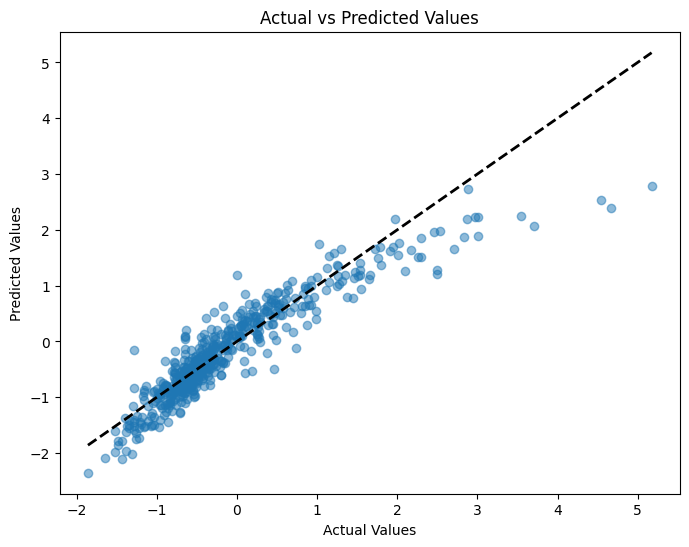

In [35]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot of actual vs predicted values
ax.scatter(y_test, y_pred, alpha=0.5)

# Add a diagonal line for reference
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Set labels and title
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Show the plot
plt.show();

What types of houses does my model have a hard time predicting? Expensive ones! I underprice them.